In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [2]:
class fitting_nohist(object):
    def __call__(self, data, time, fit_func, guess, sigmas, bounds=[]):
        self.bins  = time
        self.data  = data
        self.fit_func = fit_func
        self.guess  = guess
        self.bounds = bounds
  
        try:
            self.coeff, self.var_matrix = curve_fit(self.fit_func, self.bins,
                                                    self.data, p0=self.guess,
                                                    ftol=1E-12, maxfev=100000,
                                                    #bounds=self.bounds,
                                                    method='lm'
                                                    )

            self.perr = np.sqrt(np.absolute(np.diag(self.var_matrix)))
            # Error in parameter estimation
        except:
             print("Fitting Problems")

        self.fit = self.fit_func(self.bins, *self.coeff)
        
        self.chisq = np.sum(((self.data-self.fit)/sigmas)**2)
        self.df = len(self.bins)-len(self.coeff)
        self.chisq_r = self.chisq/self.df
        #Gets fitted function and chisqr_r

    def evaluate(self,in_data):
        return self.fit_func(in_data,*self.coeff)

In [3]:
def saturation(x,*param):
    slope = param[0]
    sat   = param[1]
    shift = param[2]
    gain  = param[3]

    value = gain*((slope*x-shift)/np.power(1+np.power((np.abs(slope*x-shift)),sat),1./sat))
    value[value<0]=np.zeros(len(value[value<0]))

    return value

In [4]:
saturation(np.array([1]),1,1,1,1)

array([0.])

In [5]:
def QDC_fit(data, canal, tac, plot=False, guess=[9.87e-03, 9.46, 3.37e-01, 6.32e+02]):
    #chisq = 100
    slope = guess[0]
    sat   = guess[1]
    shift = guess[2]
    gain  = guess[3]
    
    datos = data[(data.tac==tac)&(data.channel==canal)]

    Q_fit = fitting_nohist()
    coeff  = [slope,sat,shift,gain]

    Q_fit(datos.eval("mean"),datos.length,saturation,[slope,sat,shift,gain],datos.sigma)
    #chisq = np.sum(((datos.eval("mean")-Q_fit.evaluate(datos.length))/datos.sigma)**2)
    print("Channel = %d / CHISQ_R = %f" % (canal,Q_fit.chisq_r))
    
    max_slope  = np.max(np.diff(Q_fit.fit))/np.max(np.diff(datos.length))
    length_max = datos.length.to_numpy()
    length_max = length_max[np.argmax(np.diff(Q_fit.fit))]
    
    qoffset    = Q_fit.evaluate(np.array([length_max]))-length_max*max_slope
    print("QOFFSET = %f" % qoffset)
    print("IBIAS (Q/T) = %f" % max_slope)
       
    if plot==True:
        plt.figure()
        plt.plot(datos.length,Q_fit.evaluate(datos.length),'b-',label="Fit")
        plt.errorbar(datos.length,datos.eval("mean"), datos.sigma,
                     fmt='.',color='red',label="Data")
        plt.xlabel("Length")
        plt.ylabel("QFINE")
        plt.legend()
    
    return Q_fit.chisq_r, Q_fit, qoffset, max_slope

In [6]:
filename = "/home/viherbos/DATA_daq/qdc_calibration.h5"
data = pd.read_hdf(filename)
# Get rid off zeros in sigma and put the mean value of the other sigmas
mean_sigma = np.mean(data.sigma[data.sigma>0])
print(mean_sigma)
data.sigma=data.sigma.replace(0,mean_sigma)


0.6137989698561018


Channel = 63 / CHISQ_R = 2209.727759
QOFFSET = -203.884027
IBIAS (Q/T) = 5.677903


<IPython.core.display.Javascript object>


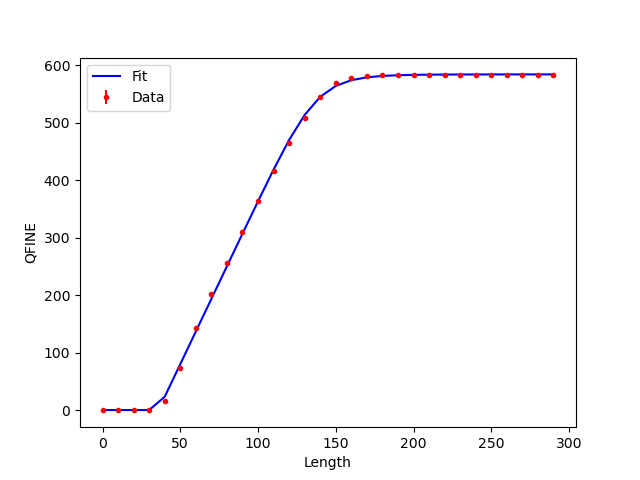

In [10]:
tac=0
#A=[QDC_fit(data, i, tac=tac) for i in range(64)]
chisq,Q_fit,qoffset,max_slope = QDC_fit(data, 63, tac=tac, plot=True)


tac=0
fig, axs = plt.subplots(4, 4)
x=y=0
for i in range(0,4):
    for j in range(0,4):
        datos = data[(data.tac==tac)&(data.channel==i*8+j)]
        axs[y,x].plot(datos.length,A[i*8+j][1].evaluate(datos.length),'b-',label="Fit")
        axs[y,x].errorbar(datos.length,datos.eval("mean"), datos.sigma,
                          fmt='.',color='red',label="Data")
        axs[y,x].set_xlabel("PHASE")
        axs[y,x].set_ylabel("QFINE")
        x=x+1
    y=y+1
    x=0
        
fig.tight_layout()
plt.legend()

tac=0
fig, axs = plt.subplots(4, 4)
x=y=0
for i in range(4,8):
    for j in range(0,4):
        datos = data[(data.tac==tac)&(data.channel==i*8+j)]
        axs[y,x].plot(datos.length,A[i*8+j][1].evaluate(datos.length),'b-',label="Fit")
        axs[y,x].errorbar(datos.length,datos.eval("mean"), datos.sigma,
                          fmt='.',color='red',label="Data")
        axs[y,x].set_xlabel("PHASE")
        axs[y,x].set_ylabel("QFINE")
        x=x+1
    y=y+1
    x=0
        
fig.tight_layout()
plt.legend()

tac=0
fig, axs = plt.subplots(4, 4)
x=y=0
for i in range(0,4):
    for j in range(4,8):
        datos = data[(data.tac==tac)&(data.channel==i*8+j)]
        axs[y,x].plot(datos.length,A[i*8+j][1].evaluate(datos.length),'b-',label="Fit")
        axs[y,x].errorbar(datos.length,datos.eval("mean"), datos.sigma,
                          fmt='.',color='red',label="Data")
        axs[y,x].set_xlabel("PHASE")
        axs[y,x].set_ylabel("QFINE")
        x=x+1
    y=y+1
    x=0
        
fig.tight_layout()
plt.legend()

tac=0
fig, axs = plt.subplots(4, 4)
x=y=0
for i in range(4,8):
    for j in range(4,8):
        datos = data[(data.tac==tac)&(data.channel==i*8+j)]
        axs[y,x].plot(datos.length,A[i*8+j][1].evaluate(datos.length),'b-',label="Fit")
        axs[y,x].errorbar(datos.length,datos.eval("mean"), datos.sigma,
                          fmt='.',color='red',label="Data")
        axs[y,x].set_xlabel("PHASE")
        axs[y,x].set_ylabel("QFINE")
        x=x+1
    y=y+1
    x=0
        
fig.tight_layout()
plt.legend()

In [8]:
CHISQR=[A[i][0] for i in range(64)]

NameError: name 'A' is not defined

In [ ]:
print(np.max(CHISQR))